In [20]:
# import widen_notebook
from mysetup import NotebookFinder
import sys
sys.meta_path.append(NotebookFinder())

from setup_transform import *
%matplotlib inline
cl_weight = sklearn.utils.compute_class_weight(class_weight='balanced',classes=[0,1,2],y=y)
CLASS_WEIGHTS = {i:cl_weight[i] for i in range(3)}    
lgr_params = dict(class_weight=CLASS_WEIGHTS,fit_intercept=True,multi_class='ovr',max_iter=200000,random_state=42,n_jobs=24, penalty ='elasticnet' ,cv=RepeatedStratifiedKFold(n_splits=3,n_repeats=5,random_state=30),scoring='f1_macro',solver='saga',Cs=100,l1_ratios= np.linspace(0,1,endpoint=False,num=10))
def_cv = RepeatedStratifiedKFold(n_splits=3,n_repeats=2,random_state=42)
from sklearnex import unpatch_sklearn
# unpatch_sklearn()
import copy
import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_master = pd.concat([raw_data.loc[:,raw_data_eval.columns],raw_data_eval],ignore_index=True,axis=0)
vc_master = {x:raw_master[x].value_counts().to_dict() for x in nominal}
def count_encode(row):
    for c in nominal:
        key = row[c]
        new_key = vc_master[c][key]
        row[c] = new_key
    return row
raw_master_ = raw_master.copy()
raw_data_ = raw_data.copy()
raw_data_eval_ = raw_data_eval.copy()
raw_data_.loc[:,nominal]=raw_data.loc[:,nominal].apply(count_encode,axis=1).astype('int')
raw_master_.loc[:,nominal]=raw_master.loc[:,nominal].apply(count_encode,axis=1).astype('int')
raw_data_eval_.loc[:,nominal]=raw_data_eval.loc[:,nominal].apply(count_encode,axis=1).astype('int')

ordinal_enc = OrdinalEncoder()
ordinal_enc.fit(raw_master_.loc[:,nominal])
raw_data_enc = ordinal_enc.transform(raw_data_.loc[:,nominal])
raw_data_eval_enc = ordinal_enc.transform(raw_data_eval_.loc[:,nominal])
raw_data_.loc[:,nominal] = raw_data_enc.astype('int')
raw_data_eval_.loc[:,nominal] = raw_data_eval_enc.astype('int')

In [3]:
raw_data.loc[:,nominal].nunique()

nominal__v_12     37
nominal__v_18     95
nominal__v_20     98
nominal__v_21     22
nominal__v_25     80
nominal__v_3     124
nominal__v_32     84
nominal__v_4      98
dtype: int64

In [4]:
raw_data_.loc[:,nominal].nunique()

nominal__v_12    13
nominal__v_18    38
nominal__v_20    37
nominal__v_21    16
nominal__v_25    39
nominal__v_3     39
nominal__v_32    39
nominal__v_4     40
dtype: int64

<AxesSubplot:>

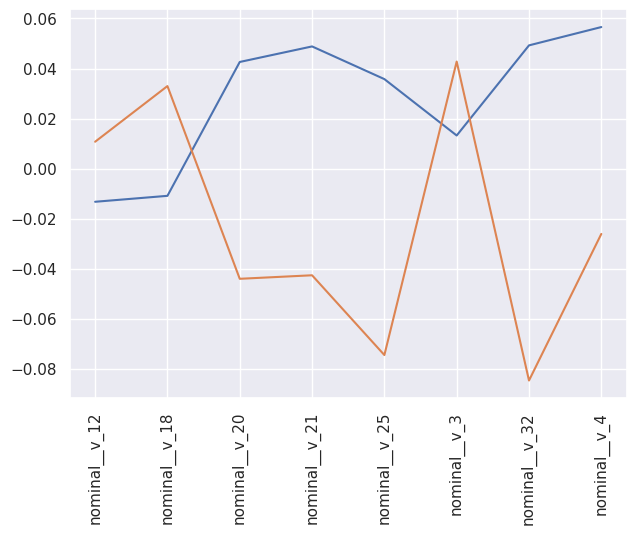

In [3]:
# SpectralClustering
raw_data_.loc[:,nominal].corrwith(raw_data.target).plot(rot=90)
raw_data.loc[:,nominal].corrwith(raw_data.target).plot(rot=90)

In [5]:
nominal_ohe = pd.get_dummies(raw_data.loc[:,nominal],columns=nominal,drop_first=False)
nominal_count_ohe = pd.get_dummies(raw_data_.loc[:,nominal],columns=nominal,drop_first=False)

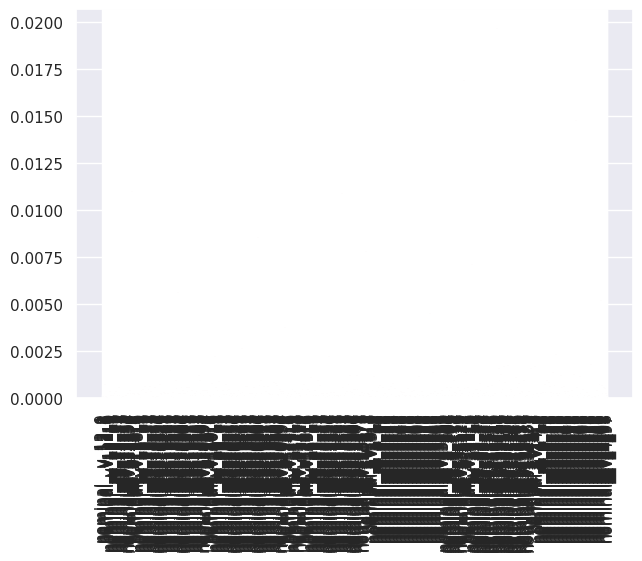

In [19]:
y = raw_data.target
plt.bar(nominal_ohe.columns,mutual_info_classif(nominal_ohe, y,discrete_features=True, random_state=42,n_neighbors=3), color='r')
# plt.bar(nominal,mutual_info_classif(raw_data_.loc[:,nominal], y,discrete_features=True,n_neighbors=3,random_state=42), color='b')

_ = plt.xticks(rotation=90)

In [32]:
from scipy.stats import chi2_contingency
import numpy as np
def cramer(data_df, varfs):
    data_encoded = pd.DataFrame() 

    for i in varfs +['target']:
        data_encoded[i]= data_df[i]



    def cramers_V(var1,var2) :
        crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
        stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
        obs = np.sum(crosstab) # Number of observations
        mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
        return (stat/(obs*mini))



    rows= []

    for var1 in data_encoded:
        col = []
        for var2 in data_encoded :
            cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
            col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
        rows.append(col)

    cramers_results = np.array(rows)
    df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)


    return df.target.iloc[:-1]

In [37]:
cramer(raw_data,nominal)

nominal__v_12    0.01
nominal__v_18    0.05
nominal__v_20    0.05
nominal__v_21    0.01
nominal__v_25    0.04
nominal__v_3     0.05
nominal__v_32    0.07
nominal__v_4     0.08
Name: target, dtype: float64

In [43]:
j_ohe = {x:sklearn.neighbors. for x in nominal_ohe.columns}
j_ohe1 = {x:0 for x in nominal_count_ohe.columns}

In [49]:
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
y = raw_data.target
# cramers_v(nominal_ohe,y)
j_ohe = {x:cramers_v(nominal_ohe[x],y) for x in nominal_ohe.columns}
j_ohe1 = {x:cramers_v(nominal_count_ohe[x],y) for x in nominal_count_ohe.columns}

In [55]:
pd.Series(j_ohe,index = nominal_ohe.columns).sort_values(ascending=False)
pd.Series(j_ohe1,index = nominal_ohe.columns).sort_values(ascending=False)

nominal__v_32_36    0.201769
nominal__v_32_38    0.179628
nominal__v_4_39     0.166739
nominal__v_4_26     0.153747
nominal__v_25_33    0.147906
                      ...   
nominal__v_4_93          NaN
nominal__v_4_94          NaN
nominal__v_4_95          NaN
nominal__v_4_96          NaN
nominal__v_4_97          NaN
Length: 638, dtype: float64